# Parameter Estimation in MAGNUS

The module `ParEst` in `MAGNUS` provides a set of methods to define, solve and analyze the results of parameter estimation problems.  `ParEst` leverages the DAG evaluation and automatic differentiation capability in `pyMC` to generate all the necessary function evaluations and derivatives internally, as well as nonlinear optimization capability provided through `CANON` (either the commercial solver [SNOPT](https://ccom.ucsd.edu/~optimizers/solvers/snopt/) or the open-source solver [IPOPT](https://projects.coin-or.org/Ipopt) depending on compilation options). Additionally, capability to embed ordinary differential equations (ODEs) into a DAG can be leveraged from `CRONOS` to enable dynamic model development.

## Parameter Estimation of a Simple Temperature-Dependent Microbial Growth Model

Consider the following model by [Ratkowski _et al_ (1983)](https://doi.org/10.1128/jb.154.3.1222-1226.1983) describing the effect of culture temperature, $T$ on the growth rate, $\mu$ of a microbial population:
$$\begin{align}
\mu(T) = \left[b\left(T - T_{\rm min}\right)\left(1 - {\rm e}^{c(T - T_{\rm max})}\right) \right]^2
\end{align}$$
where $T_{\rm min}$ and $T_{\rm max}$ $[\rm K]$ represent the minimal and maximal temperatures, respectively, while $b$ $[\mathrm{K}^{-1}\mathrm{h}^{0.5}]$ and $c$ $[\mathrm{K}^{-1}]$ are extra parameters adding flexibility to the shape of the growth model.

Experimental data used in the regression are also from [Ratkowski _et al_ (1983)](https://doi.org/10.1128/jb.154.3.1222-1226.1983) for the bacterium _E. coli_. This data set comprises $15$ measurement pairs $(T_k,\mu_k)$ within the temperature range $294-320~\rm [K]$. The standard deviation of the growth rate measurements is taken as $\sigma_\mu=0.1~[\mathrm{h}^{-1}]$.

We start by importing both the `PyMC` module and `ParEst` method in the `MAGNUS` module:

In [1]:
import pymc
from magnus import ParEst

Next, we define the DAG of the growth model in `pyMC`:

In [2]:
# Create DAG
DAG = pymc.FFGraph()
DAG.options.MAXTHREAD = 1

# Model parameters
Tmin = pymc.FFVar( DAG, "Tmin" )
Tmax = pymc.FFVar( DAG, "Tmax" )
b    = pymc.FFVar( DAG, "b" )
c    = pymc.FFVar( DAG, "c" )

# Control variable and model output
T    = pymc.FFVar( DAG, "T" )
Y    = pymc.pow( b * ( T - Tmin ) * ( 1 - pymc.exp( c * ( T - Tmax ) ) ), 2 )
print( Y.str() )

SQR( ( b * ( T - Tmin ) ) * ( ( - EXP( c * ( T - Tmax ) ) ) + 1 ) )


We instantiate an environment `ParEst` and set a few options:

In [3]:
# Instantiate parameter estimation solver
PE = ParEst()

PE.options.DISPLEVEL = 1
PE.options.NLPSLV.DISPLEVEL   = 0;
PE.options.NLPSLV.GRADCHECK   = 0;
PE.options.NLPSLV.MAXTHREAD   = 0;
PE.options.NLPSLV.GRADMETH    = PE.options.NLPSLV.FSYM

PE.set_dag( DAG )

We define and set the experimental data, where the first field of `ParEst.Experiment` corresponds to the control value and the second field sets the value and variance of the measured variable with index `0`:

In [4]:
# Experimental data
Data = [
  ParEst.Experiment( [294], { 0: ParEst.Record( [0.25], 0.01 ) } ),
  ParEst.Experiment( [296], { 0: ParEst.Record( [0.56], 0.01 ) } ),
  ParEst.Experiment( [298], { 0: ParEst.Record( [0.61], 0.01 ) } ),
  ParEst.Experiment( [300], { 0: ParEst.Record( [0.79], 0.01 ) } ),
  ParEst.Experiment( [302], { 0: ParEst.Record( [0.94], 0.01 ) } ),
  ParEst.Experiment( [304], { 0: ParEst.Record( [1.04], 0.01 ) } ),
  ParEst.Experiment( [306], { 0: ParEst.Record( [1.16], 0.01 ) } ),
  ParEst.Experiment( [308], { 0: ParEst.Record( [1.23], 0.01 ) } ),
  ParEst.Experiment( [310], { 0: ParEst.Record( [1.36], 0.01 ) } ),
  ParEst.Experiment( [312], { 0: ParEst.Record( [1.32], 0.01 ) } ),
  ParEst.Experiment( [314], { 0: ParEst.Record( [1.36], 0.01 ) } ),
  ParEst.Experiment( [316], { 0: ParEst.Record( [1.34], 0.01 ) } ),
  ParEst.Experiment( [318], { 0: ParEst.Record( [0.96], 0.01 ) } ),
  ParEst.Experiment( [319], { 0: ParEst.Record( [0.83], 0.01 ) } ),
  ParEst.Experiment( [320], { 0: ParEst.Record( [0.16], 0.01 ) } )
]
PE.set_data( Data );

We also set the output and control in the model together with the estimated parameters and their bounds:

In [5]:
PE.add_model( [Y], [T] )
PE.set_parameter( [Tmin, Tmax, b, c], [ 255, 315, 0.01, 0.05 ], [ 290, 330, 0.1,  1.0  ] )

After setup, we conduct a maximum likelihood estimation (MLE) using the method `mle_solve`, which calls the local NLP solver available through `CANON` from a specified initial guess for the decision variables:

In [6]:
PE.setup()
PE.mle_solve( [ 275, 320, 0.03, 0.3  ] )
#print( PE.mle )


# MAXIMUM LIKELIHOOD ESTIMATE:
STATUS: 1
P[0]:  2.735410e+02
P[1]:  3.213742e+02
P[2]:  3.247559e-02
P[3]:  3.357089e-01
LIKELIHOOD:  6.468124e+00


1

We can also conduct a multi-start local search to reduce the odds of determining a suboptimal fit, which requires the model parameter domain to be bounded, by passing the number of trial starting points to the method `mle_solve':

In [7]:
PE.mle_solve( 16 )
mleopt = PE.par_best


MULTISTART: ****************

# MAXIMUM LIKELIHOOD ESTIMATE:
STATUS: 1
P[0]:  2.735410e+02
P[1]:  3.213742e+02
P[2]:  3.247559e-02
P[3]:  3.357089e-01
LIKELIHOOD:  6.468124e+00


A plot of the resulting fit is shown below:

In [8]:
import numpy as np
import matplotlib.pyplot as plt

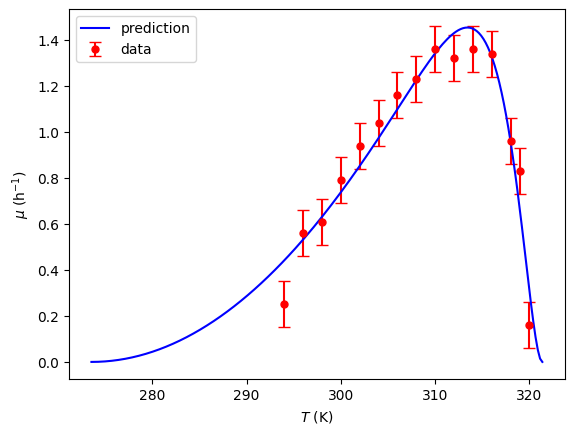

In [9]:
N = 200
Tgrid = np.linspace( mleopt[0], mleopt[1], N )
#print( Tgrid )

mugrid = []
for Tval in Tgrid:
   mugrid.append( DAG.eval( [Y], [T, Tmin,Tmax,b,c], [Tval]+mleopt ) )
mugrid = np.array( mugrid ) # convert list into numpy array
#print( mugrid )

Tmeas, mumeas, mustd = [], [], []
for Exp in Data:
    Tmeas.append( Exp.control[0] )
    mumeas.append( Exp.output[0].measurement[0] )
    mustd.append( np.sqrt(Exp.output[0].variance) )
#print( Tmeas, mumeas, mustd )

plt.xlabel("$T$ (K)")
plt.ylabel("$μ$ (h$^{-1}$)")
plt.errorbar(Tmeas, mumeas, yerr=mustd, marker='o', ms=5, c='r', ls='', capsize=4, label="data")
plt.plot(Tgrid, mugrid, "-b", label="prediction")
plt.legend(loc="best")
plt.show()

We can check the goodness-of-fit test based on $\chi^2$ statistics, for instance at 95% confidence level:

In [10]:
chi2 = PE.chi2_test( 0.95 )
#print( chi2 )


# CHI-SQUARED TEST: 1.294e+01 < 1.968e+01 CRITICAL CHI_SQUARED VALUE (95%, 11 DOF)
# CHI-SQUARED TEST PASSED WITH >70% CONFIDENCE LEVEL


Knowing that the model structure is adequate, we can compute an estimate of the covariance matrix and compute 95% confidence intervals (here based on Student's t-distribution) as follows: 

In [11]:
lincov = PE.cov_linearized()
cint95 = PE.conf_interval( lincov, 0.95, "T" )


# PARAMETER COVARIANCE MATRIX (FROM LINEARIZATION):
2.60183e+01 2.44991e+00 3.00885e-02 -5.51435e-01
2.44991e+00 3.99731e-01 3.00861e-03 -7.50224e-02
3.00885e-02 3.00861e-03 3.53337e-05 -6.72604e-04
-5.51435e-01 -7.50224e-02 -6.72604e-04 1.55085e-02

# 95% PARAMETER CONFIDENCE INTERVALS:
1.12268e+01 1.39156e+00 1.30831e-02 2.74095e-01


We can also use the covariance matrix to plot 95% confidence ellipsoids (here based on Fisher's F-distribution):

In [12]:
cell95_Tmin_Tmax = PE.conf_ellipsoid( lincov, 0, 1, 0.95, "F", 50 )


# 95% CONFIDENCE ELLIPSOID FOR PARAMETERS (0,1):
[matrix size: 50x2]
   2.9373e+02   3.2313e+02
   2.9379e+02   3.2335e+02
   2.9352e+02   3.2353e+02
            :            :            
   2.9373e+02   3.2313e+02


As an alternative to the linearization approach, we can generate confidence regions via bootstrapping:

In [13]:
PE.options.DISPLEVEL = 1
PE.bootstrap_sample( 1028 )
bootcov = PE.cov_sample()
bootsam = PE.par_sample


# BOOTSTRAPPED CONFIDENCE REGION:
    0: 2.73795e+02 3.21467e+02 3.24951e-02 3.29480e-01
    1: 2.72498e+02 3.21170e+02 3.10381e-02 3.69771e-01
    2: 2.77046e+02 3.21588e+02 3.71633e-02 2.81697e-01
   ...
 1025: 2.78011e+02 3.22052e+02 3.98067e-02 2.23925e-01
 1026: 2.70001e+02 3.22251e+02 2.99313e-02 2.60700e-01
 1027: 2.74192e+02 3.22693e+02 3.31572e-02 2.51578e-01

# PARAMETER COVARIANCE MATRIX (FROM SAMPLE):
1.44115e+01 8.05775e-01 1.62033e-02 -2.15658e-01
8.05775e-01 2.10036e-01 1.09618e-03 -3.12782e-02
1.62033e-02 1.09618e-03 1.95432e-05 -2.68951e-04
-2.15658e-01 -3.12782e-02 -2.68951e-04 6.46378e-03


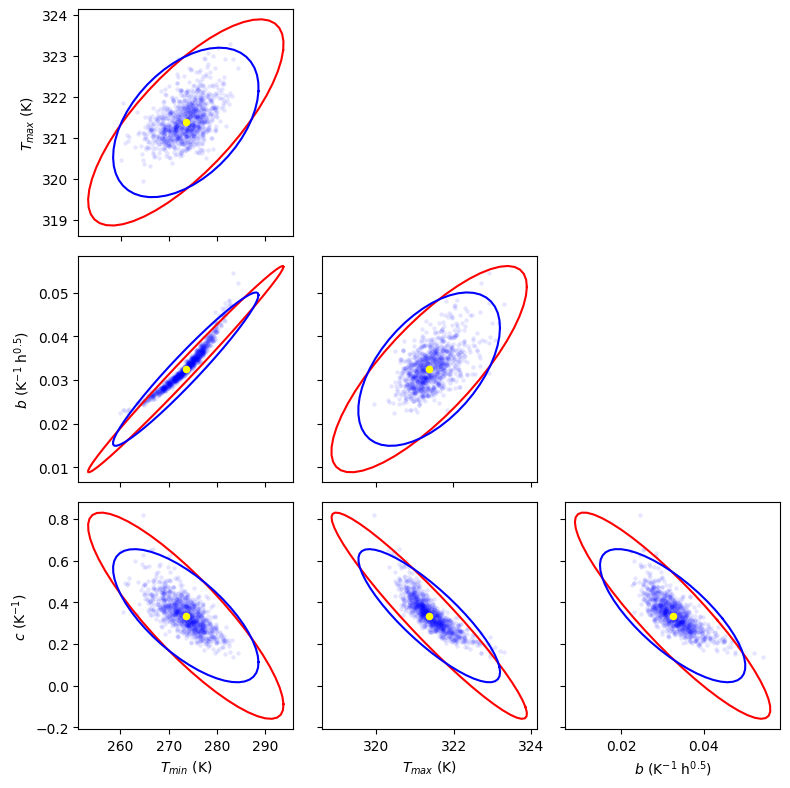

In [14]:
PE.options.DISPLEVEL = 0

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i in [0,1,2]:
   for j in [1,2,3]:
       if j <= i: continue
       cell95 = PE.conf_ellipsoid( lincov, i, j, 0.95, "F", 50 )
       axes[j-1,i].plot( cell95[:,0], cell95[:,1], color="red" )
       cell95 = PE.conf_ellipsoid( bootcov, i, j, 0.95, "F", 50 )
       axes[j-1,i].plot( cell95[:,0], cell95[:,1], color="blue" )
       axes[j-1,i].scatter(bootsam[:,i], bootsam[:,j], s=10, lw=0, color="blue", alpha=0.1 )
       axes[j-1,i].scatter( mleopt[i], mleopt[j], s=30, lw=0, color="yellow" )
       #axes[j-1,i].set(adjustable='box-forced', aspect='equal')
       if i == 0:
           axes[j-1,i].set(xlabel="$T_{min}$ (K)")
       elif i == 1:
           axes[j-1,i].set(xlabel="$T_{max}$ (K)")
       elif i == 2:
           axes[j-1,i].set(xlabel="$b$ (K$^{-1}$ h$^{0.5}$)")
       if j == 1:
           axes[j-1,i].set(ylabel="$T_{max}$ (K)")
       elif j == 2:
           axes[j-1,i].set(ylabel="$b$ (K$^{-1}$ h$^{0.5}$)")
       elif j == 3:
           axes[j-1,i].set(ylabel="$c$ (K$^{-1}$)")

[ fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data() ]
[ ax.label_outer() for ax in fig.get_axes() ]
fig.tight_layout()

Next, we conduct a Bayesian estimation (BE) using the method `bpe_solve`, which uses a nested sampling algorithm to compute the evidence:

In [15]:
PE.options.NSSLV.DISPLEVEL    = 1
PE.options.NSSLV.DISPITER     = 500
PE.options.NSSLV.NUMLIVE      = 500
PE.options.NSSLV.NUMPROP      = 50
PE.options.NSSLV.LKHTOL       = 0.01
PE.options.DISPLEVEL = 1

PE.bpe_solve()
bpemap        = PE.par_best
[bpesam,_]    = PE.hpd_region( 0.95 )
[bpelb,bpeub] = PE.hpd_interval( 0.95 )



** INITIALIZING LIVE POINTS (500)      0.00 SEC

Iterate        Contour    #Dead           Mass           Nest         Factor
----------------------------------------------------------------------------
      0    -4.3551e+11        0     0.0000e+00     0.0000e+00     3.0000e-01
    500    -5.7111e+01     2179    -6.5353e+01    -1.8203e+01     1.2548e-01
   1000    -3.4028e+01     2633    -4.1999e+01    -1.8205e+01     1.0465e-01
   1500    -2.6342e+01     2904    -3.4566e+01    -1.7917e+01     9.3896e-02
   2000    -2.2030e+01     3105    -3.0518e+01    -1.7936e+01     8.6642e-02
   2500    -1.9608e+01     3252    -2.8123e+01    -1.7501e+01     8.1694e-02
   3000    -1.7840e+01     3393    -2.6318e+01    -1.7382e+01     7.7214e-02
   3500    -1.6647e+01     3519    -2.5131e+01    -1.7338e+01     7.3419e-02
   4000    -1.5732e+01     3615    -2.4338e+01    -1.7459e+01     7.0653e-02
   4500    -1.5144e+01     3703    -2.3699e+01    -1.7400e+01     6.8209e-02
   5000    -1.4187e+01    

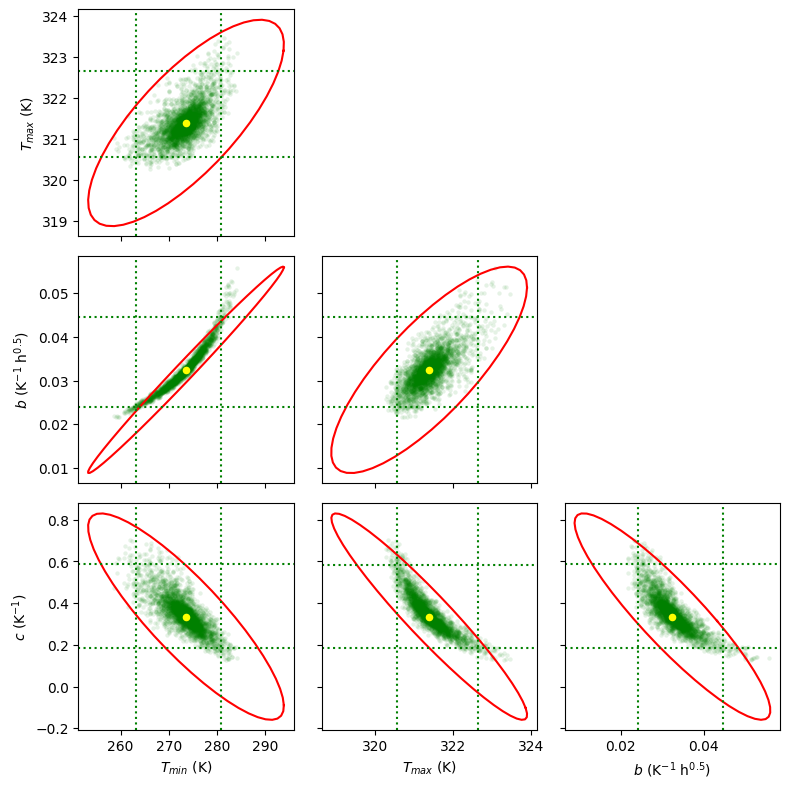

In [16]:
PE.options.DISPLEVEL = 0

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i in [0,1,2]:
   for j in [1,2,3]:
       if j <= i: continue
       cell95 = PE.conf_ellipsoid( lincov, i, j, 0.95, "F", 50 )
       axes[j-1,i].plot( cell95[:,0], cell95[:,1], color="red" )
       #axes[j-1,i].scatter( bootsam[:,i], bootsam[:,j], s=10, lw=0, color="blue", alpha=0.1 )
       axes[j-1,i].scatter( bpesam[:,i], bpesam[:,j], s=10, lw=0, color="green", alpha=0.1 )
       axes[j-1,i].axvline( bpelb[i], ls=':', color="green" )
       axes[j-1,i].axvline( bpeub[i], ls=':', color="green" )
       axes[j-1,i].axhline( bpelb[j], ls=':', color="green" )
       axes[j-1,i].axhline( bpeub[j], ls=':', color="green" )
       axes[j-1,i].scatter( bpemap[i], bpemap[j], s=30, lw=0, color="yellow" )
       #axes[j-1,i].set(adjustable='box-forced', aspect='equal')
       if i == 0:
           axes[j-1,i].set(xlabel="$T_{min}$ (K)")
       elif i == 1:
           axes[j-1,i].set(xlabel="$T_{max}$ (K)")
       elif i == 2:
           axes[j-1,i].set(xlabel="$b$ (K$^{-1}$ h$^{0.5}$)")
       if j == 1:
           axes[j-1,i].set(ylabel="$T_{max}$ (K)")
       elif j == 2:
           axes[j-1,i].set(ylabel="$b$ (K$^{-1}$ h$^{0.5}$)")
       elif j == 3:
           axes[j-1,i].set(ylabel="$c$ (K$^{-1}$)")

[ fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data() ]
[ ax.label_outer() for ax in fig.get_axes() ]
fig.tight_layout()